### Memprediksi kemenangan suatu tim dari 10 menit pertama game

Pada dataset ini kita akan memprediksi suatu tim, apakah mereka akan memenangkan permainan League of Legend berdasarkan data 10 menit pertama saat game dimulai. Model yang dihasilkan dapat digunakan untuk para coach/kapten untuk memperkirakan akhir permainan guna menyusun strategi baru bila dirasa perlu untuk menang. Perlu diingat match ini diambil pada kategori rank diamond. Asumsi permainan adalah menggunakan META yang berlaku dikalangan player veteran diterapkan pada model ini.

In [61]:
#Package import
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns     
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

In [62]:
#Data Retrieval
data = pd.read_csv('high_diamond_ranked_10min.csv')
matchData = data

In [63]:
#Dataset info
print('Shape of dataset', matchData.shape)
print('Dataset type', matchData.dtypes)
matchData.head()

Shape of dataset (9879, 40)
Dataset type gameId                            int64
blueWins                          int64
blueWardsPlaced                   int64
blueWardsDestroyed                int64
blueFirstBlood                    int64
blueKills                         int64
blueDeaths                        int64
blueAssists                       int64
blueEliteMonsters                 int64
blueDragons                       int64
blueHeralds                       int64
blueTowersDestroyed               int64
blueTotalGold                     int64
blueAvgLevel                    float64
blueTotalExperience               int64
blueTotalMinionsKilled            int64
blueTotalJungleMinionsKilled      int64
blueGoldDiff                      int64
blueExperienceDiff                int64
blueCSPerMin                    float64
blueGoldPerMin                  float64
redWardsPlaced                    int64
redWardsDestroyed                 int64
redFirstBlood                     int64

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


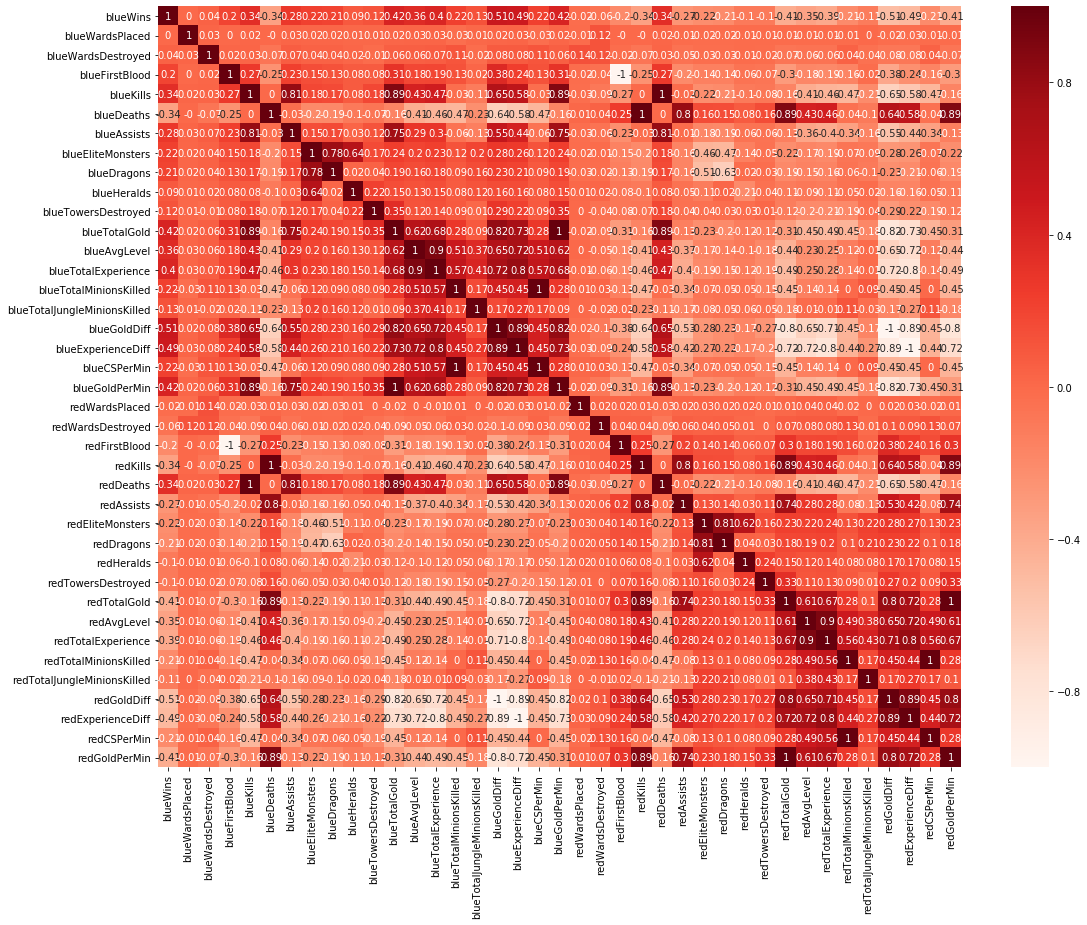

In [64]:
#Correlation matrix heatmap
plt.figure(figsize=(18,14))
sns.heatmap(round(matchData.iloc[:,1:].corr(),2), cmap='Reds', annot=True)
plt.show()

In [65]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [66]:
calc_vif(matchData.iloc[:,1:])

,variables,VIF
0,blueWins,1.391451
1,blueWardsPlaced,1.026960
2,blueWardsDestroyed,1.068408
3,blueFirstBlood,1299.014983
4,blueKills,inf
5,blueDeaths,inf
6,blueAssists,3.770062
7,blueEliteMonsters,inf
8,blueDragons,inf
9,blueHeralds,inf


Dari matrix diatas dan tes VIF, kita melihat banyak terjadi multicollinearity, maka kita perlu menghapus beberapa variabel terutama yang saling mempengaruhi seperti "Death" pada "Kill" atau "experience" pada "jumlah kill minion" dan seterusnya.

In [90]:
BluePredictor = matchData[['blueFirstBlood', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueDragons', 'blueHeralds', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueTowersDestroyed']]
RedPredictor = matchData[['redWardsPlaced', 'redWardsDestroyed', 'redKills', 'redDragons', 'redHeralds', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redTowersDestroyed']]

In [97]:
features = pd.concat([BluePredictor, RedPredictor], axis=1, sort=False)
labels = matchData['blueWins'].astype('category')

In [98]:
features['blueTotalNormalMinion'] = features['blueTotalMinionsKilled']-features['blueTotalJungleMinionsKilled']
features['redTotalNormalMinion'] = features['redTotalMinionsKilled']-features['redTotalJungleMinionsKilled']
features = features.drop(['blueTotalMinionsKilled', 'redTotalMinionsKilled'], axis=1)
features.head()

,blueFirstBlood,blueWardsPlaced,blueWardsDestroyed,blueKills,blueDragons,blueHeralds,blueTotalJungleMinionsKilled,blueTowersDestroyed,redWardsPlaced,redWardsDestroyed,redKills,redDragons,redHeralds,redTotalJungleMinionsKilled,redTowersDestroyed,blueTotalNormalMinion,redTotalNormalMinion
0,1,28,2,9,0,0,36,0,15,6,6,0,0,55,0,159,142
1,0,12,1,5,0,0,43,0,12,1,5,1,1,52,1,131,188
2,0,15,0,7,1,0,46,0,15,3,11,0,0,28,0,140,175
3,0,43,1,4,0,1,55,0,15,2,5,0,0,47,0,146,188
4,0,75,4,6,0,0,57,0,17,2,6,1,0,67,0,153,158


In [99]:
calc_vif(features)

,variables,VIF
0,blueFirstBlood,2.339436
1,blueWardsPlaced,2.558170
2,blueWardsDestroyed,2.850331
3,blueKills,6.241593
4,blueDragons,2.733880
5,blueHeralds,1.382309
6,blueTotalJungleMinionsKilled,26.635392
7,blueTowersDestroyed,1.157790
8,redWardsPlaced,2.513832
9,redWardsDestroyed,2.772446


### Naive Bayes

In [107]:
#import naive bayes
from sklearn.naive_bayes import GaussianNB

#create package object
nb = GaussianNB()

In [108]:
#Perform k=5 fold cross validation
predictions = cross_val_predict(nb, features, labels, cv=5)
predictions[0:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [109]:
#Scoring
accuracy_score(labels, predictions)

0.6953132908189088

### Logistic Regression

In [110]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

In [111]:
#Perform k=5 fold cross validation
predictions = cross_val_predict(logreg, features, labels, cv=5)
predictions[0:5]

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

array([1, 0, 0, 0, 0], dtype=int64)

In [112]:
#Scoring
accuracy_score(labels, predictions)

0.7199109221581131

### Random Forest Clasification

In [113]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#create package object
rfModel = RandomForestClassifier(n_estimators=100)

In [114]:
#Perform k=5 fold cross validation
predictions = cross_val_predict(rfModel, features, labels, cv=5)
predictions[0:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [115]:
#Scoring
accuracy_score(labels, predictions)

0.7067516955157405

#### Logistic Regression memiliki akurasi lebih tinggi dari yang lain, yakni sebesar 71% dari algoritma lainnya

kita dapat mencari prediktor terkuat dengan menggunakan logistic regression

In [145]:
model = logreg.fit(features, labels)
cdf = pd.DataFrame(data = model.coef_.reshape(-1,1), index = features.columns, columns = ['Coefficients'])
cdf

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Coefficients
blueFirstBlood,0.074655
blueWardsPlaced,-0.000962
blueWardsDestroyed,0.007726
blueKills,0.248307
blueDragons,0.290108
blueHeralds,0.088577
blueTotalJungleMinionsKilled,0.033537
blueTowersDestroyed,0.361570
redWardsPlaced,-0.002247
redWardsDestroyed,-0.008465


Dari sini kita dapat mengetahui bahwa mendapatkan buff dragon dan herald di 10 menit pertama sangat mempengaruhi kemenangan pada match